# Methods and models for multivariate data analysis. Lab 2

## <font color='darkblue'> **Aleksandr Shirokov, J4133c** </font>

In [2]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import statsmodels

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats.distributions import norm

from definitions import ROOT_DIR

%matplotlib inline

In [3]:
for library in [np, pd, sns, scipy, sklearn, statsmodels]:
    print(f'{library.__name__}=={library.__version__}')

numpy==1.20.1
pandas==1.2.3
seaborn==0.11.2
scipy==1.6.1
sklearn==1.0.1
statsmodels==0.13.1


## Dataset

To use dataset you need:

- Download dataset from this [link](https://www.kaggle.com/devbcdestiller/bitcoin-usdt-price-trend-indicators) and save it in `data` folder with filename `data.csv`

- Apply several feature engineering using code below:

In [4]:
DATA_PATH = ROOT_DIR / 'data'

data = pd.read_csv(DATA_PATH / 'data.csv')

**Feature engineering for dataset**

In [5]:
data['quantile_Volume'] = pd.qcut(data['Volume'], q=4)
data['quantile_RSI'] = pd.qcut(data['RSI'], q=4)
data['quantile_STOCHRSI-K'] = pd.qcut(data['STOCHRSI-K'], q=4)
data['quantile_STOCHRSI-D'] = pd.qcut(data['STOCHRSI-D'], q=4)
data['month'] = data.dt.apply(lambda x: pd.to_datetime(x).month)
data = data.drop('dt', axis=1)

## Additional Data Preprocessing

In [6]:
quantile_map = dict(
    zip(
        map(
            lambda x: str(x), 
            np.sort(data['quantile_Volume'].unique())
        ), 
        range(1, 5)
    )
)
quantile_map

{'(5.885999999999999, 1560.863]': 1,
 '(1560.863, 2298.493]': 2,
 '(2298.493, 3550.281]': 3,
 '(3550.281, 44239.812]': 4}

In [7]:
columns = data.columns

target = ['Close']
features = ['Open', 'Volume', 'RSI', 'MACD Signal', 'month', 'STOCHRSI-D']
categories = ['quantile_Volume']

In [8]:
data['quantile_Volume']= data['quantile_Volume'].astype(str).map(quantile_map)

In [9]:
for col in features + categories:
    data[col] = data[col].fillna(data[col].median())

In [10]:
data = data[features + categories + target]
columns = features + categories + target

## Subtask 1.


*Non-parametric estimation of PDF in:*

- form of histogram

- using kernel density function for MRV (or probability law in case of discrete MRV)

Firstly let's show the histograms of each variable.

In [11]:
pair_columns = [
    x for x in columns if x not in 
    ['quantile_Volume', 'month']
] # this variables are categorical

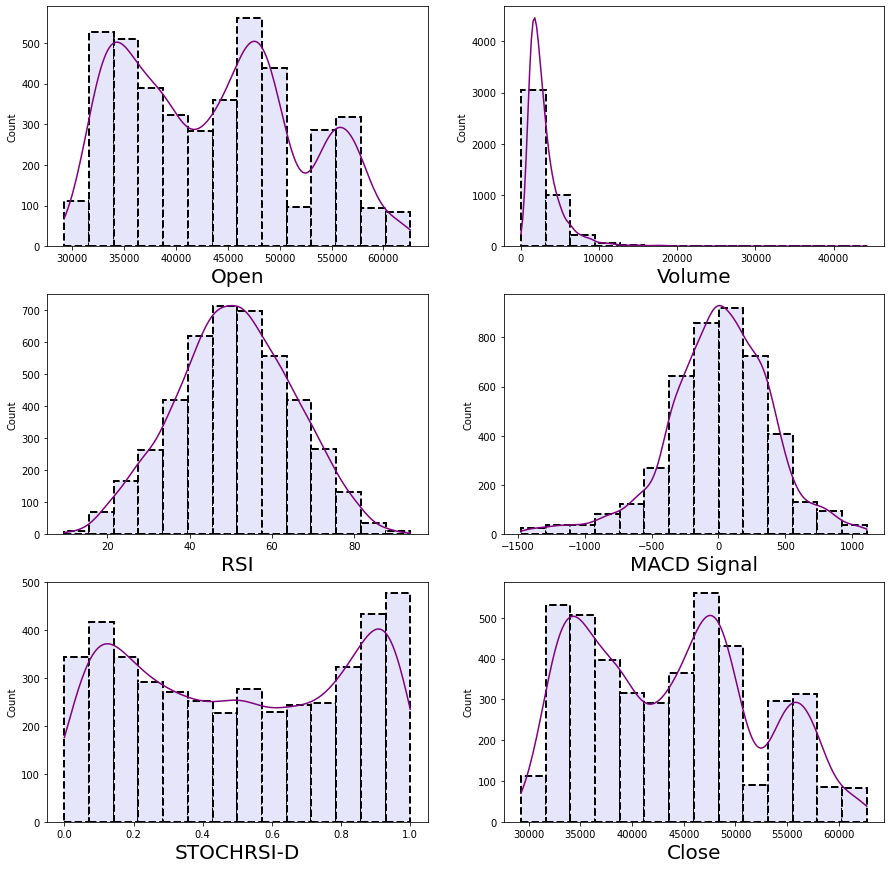

In [12]:
hist_plot_kwargs ={
    'color':'lavender', 
    'edgecolor':'black',
    'linewidth':2, 
    'linestyle':'--', 
    'alpha':1
}

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for ax, cols in zip(axes.flat, pair_columns):
    b = sns.histplot(
        data[cols], 
        ax=ax, 
        bins='sturges',
        kde=True,
        **hist_plot_kwargs,
    )
    ax.lines[0].set_color('purple')
    ax.set_xlabel(cols, fontsize=20)

plt.show()

And now let's show the MRV non-parametric estimation of pdf. Variable `month` was used as a hue.

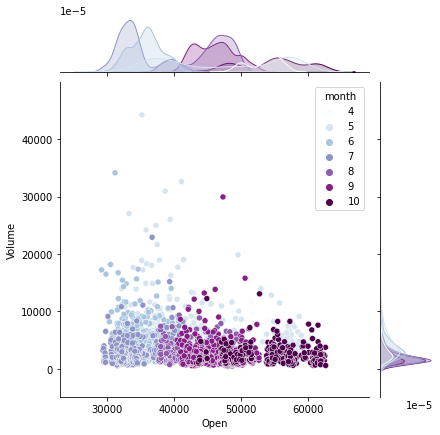

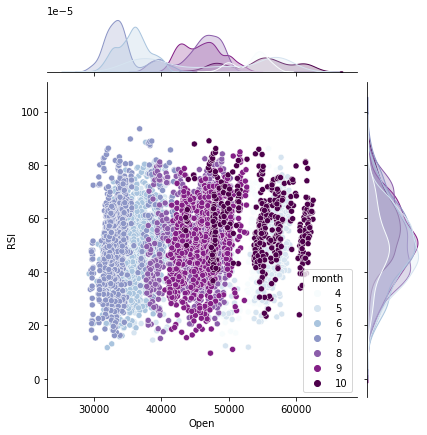

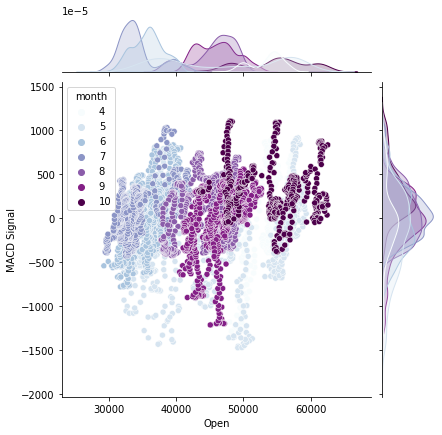

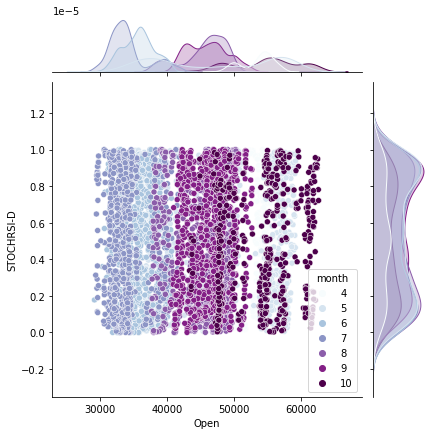

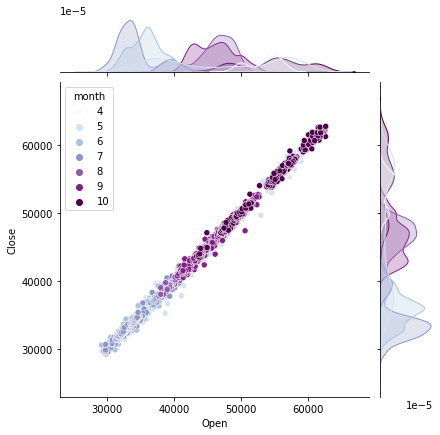

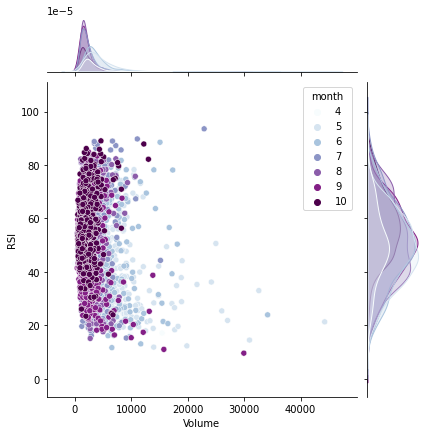

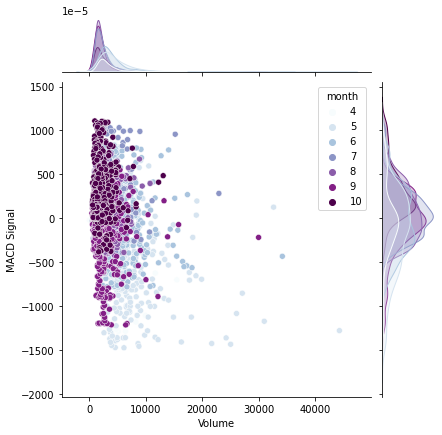

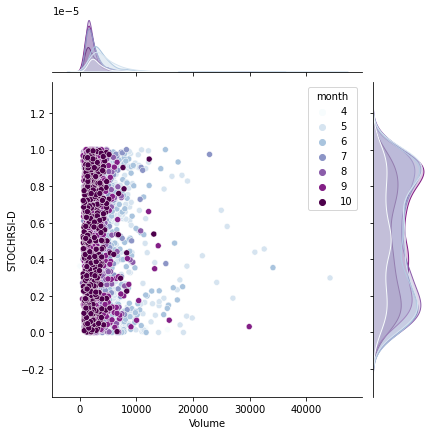

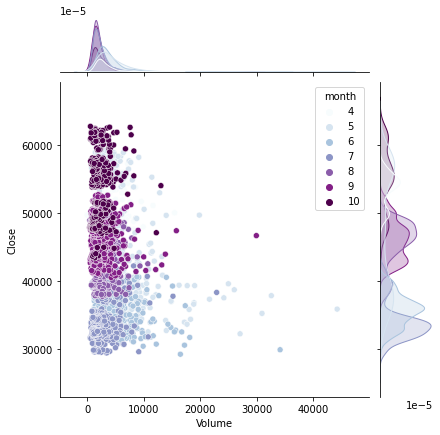

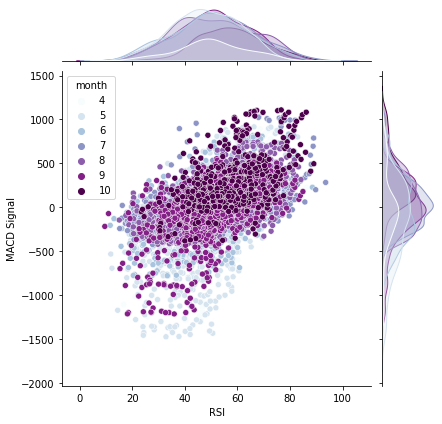

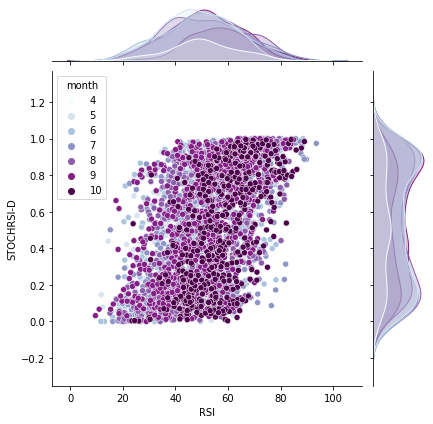

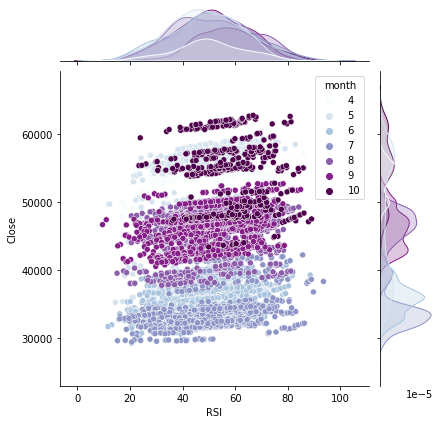

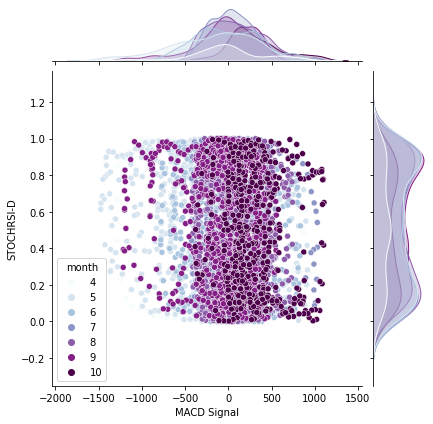

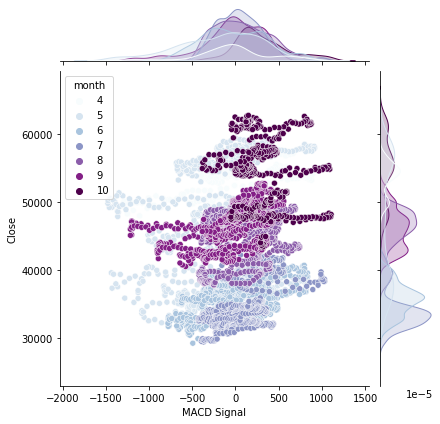

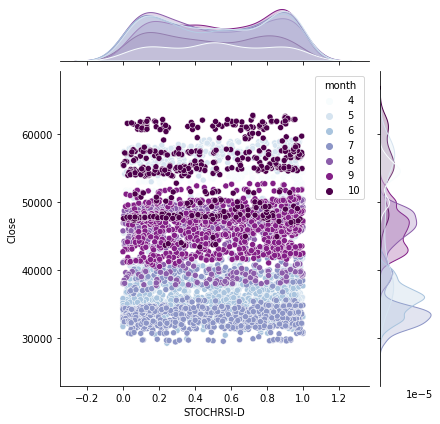

In [13]:
from itertools import combinations

pairs = list(combinations(pair_columns, 2))

for col1, col2 in pairs:
    sns.jointplot(
        data=data, 
        x=data[col1], 
        y=data[col2],
        hue='month', 
        palette='BuPu',
    )
    plt.show()

## Subtask 2.

*An estimation of multivariate mathematical expectation and variance*.


In [14]:
data[columns].mean()

Open               43744.748055
Volume              3018.940768
RSI                   50.929004
MACD Signal            9.319127
month                  7.101575
STOCHRSI-D             0.510336
quantile_Volume        2.499658
Close              43746.064022
dtype: float64

In [15]:
data[columns].var()

Open               6.876476e+07
Volume             6.748538e+06
RSI                2.007612e+02
MACD Signal        1.496410e+05
month              3.127351e+00
STOCHRSI-D         9.952140e-02
quantile_Volume    1.250514e+00
Close              6.880793e+07
dtype: float64

## Subtask 3.

*Non-parametric estimation of conditional distributions, mathematical expectations and variances.*

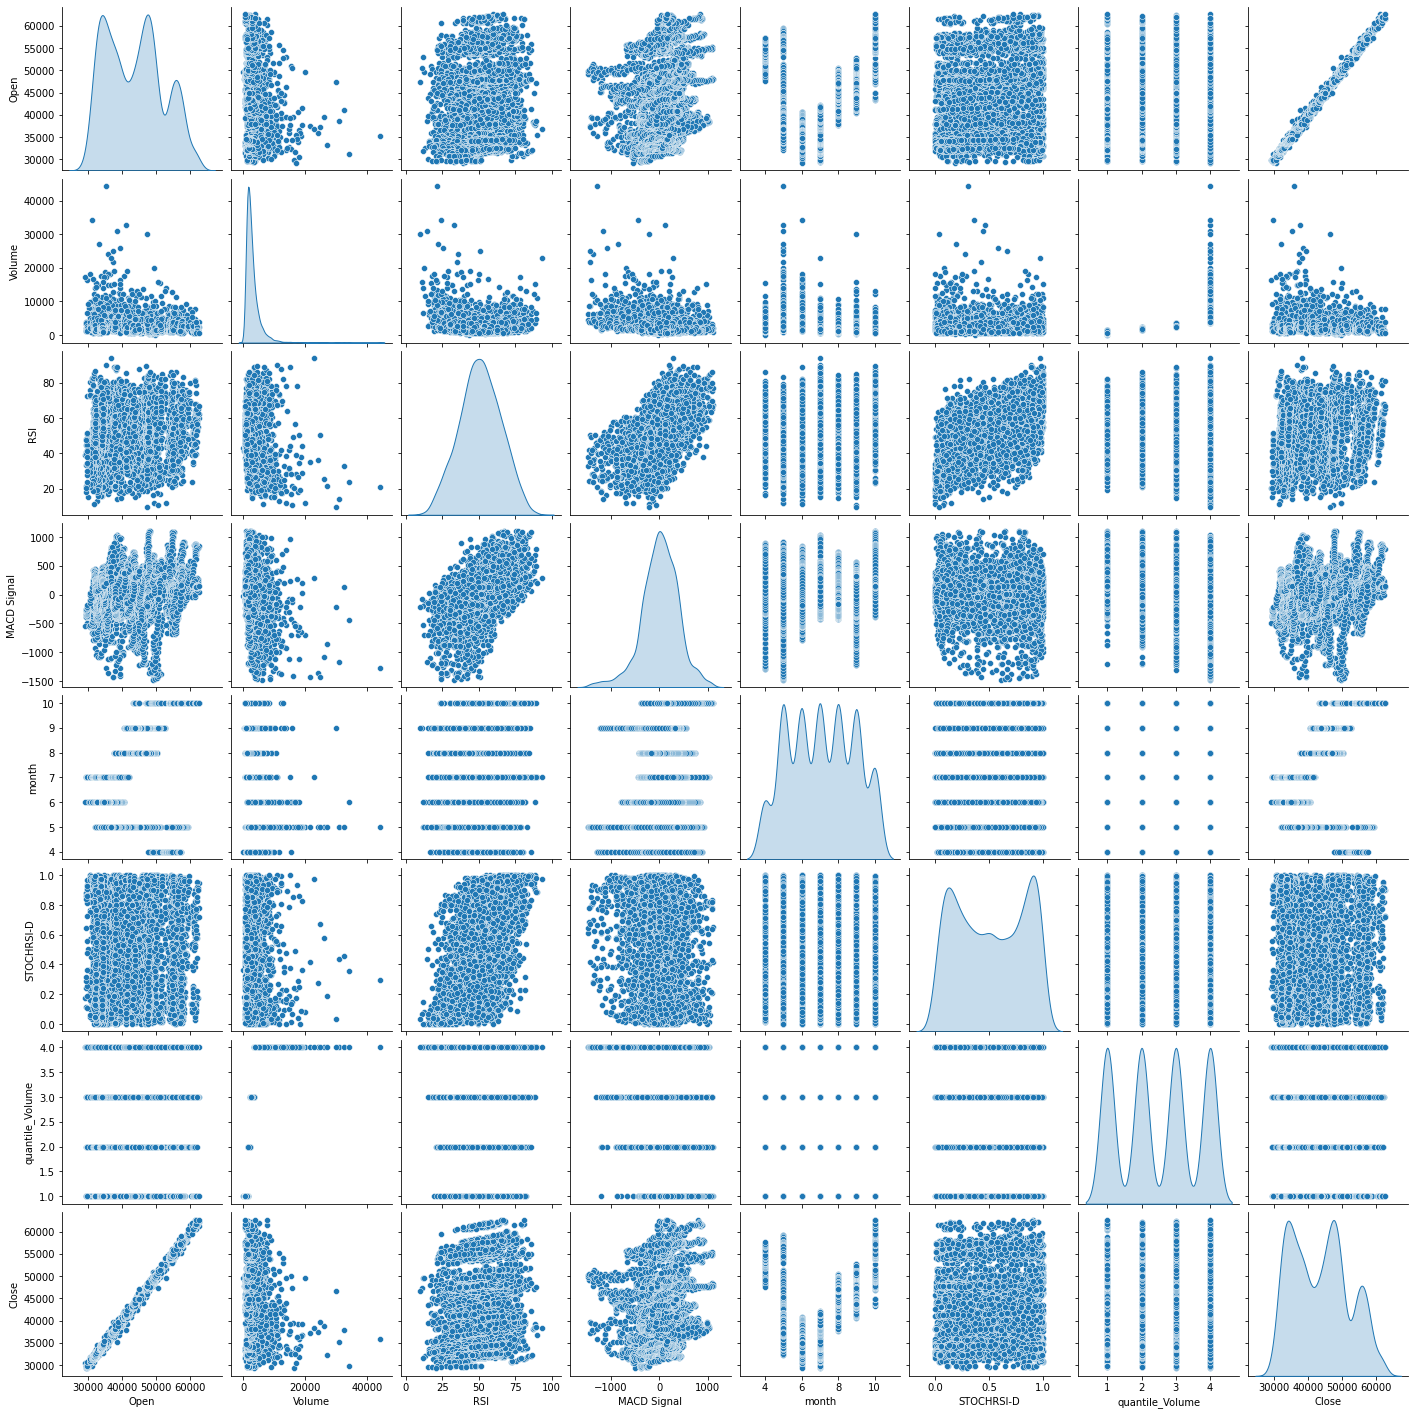

In [16]:
sns.pairplot(data[columns], diag_kind='kde', palette='BuPu')
plt.show()

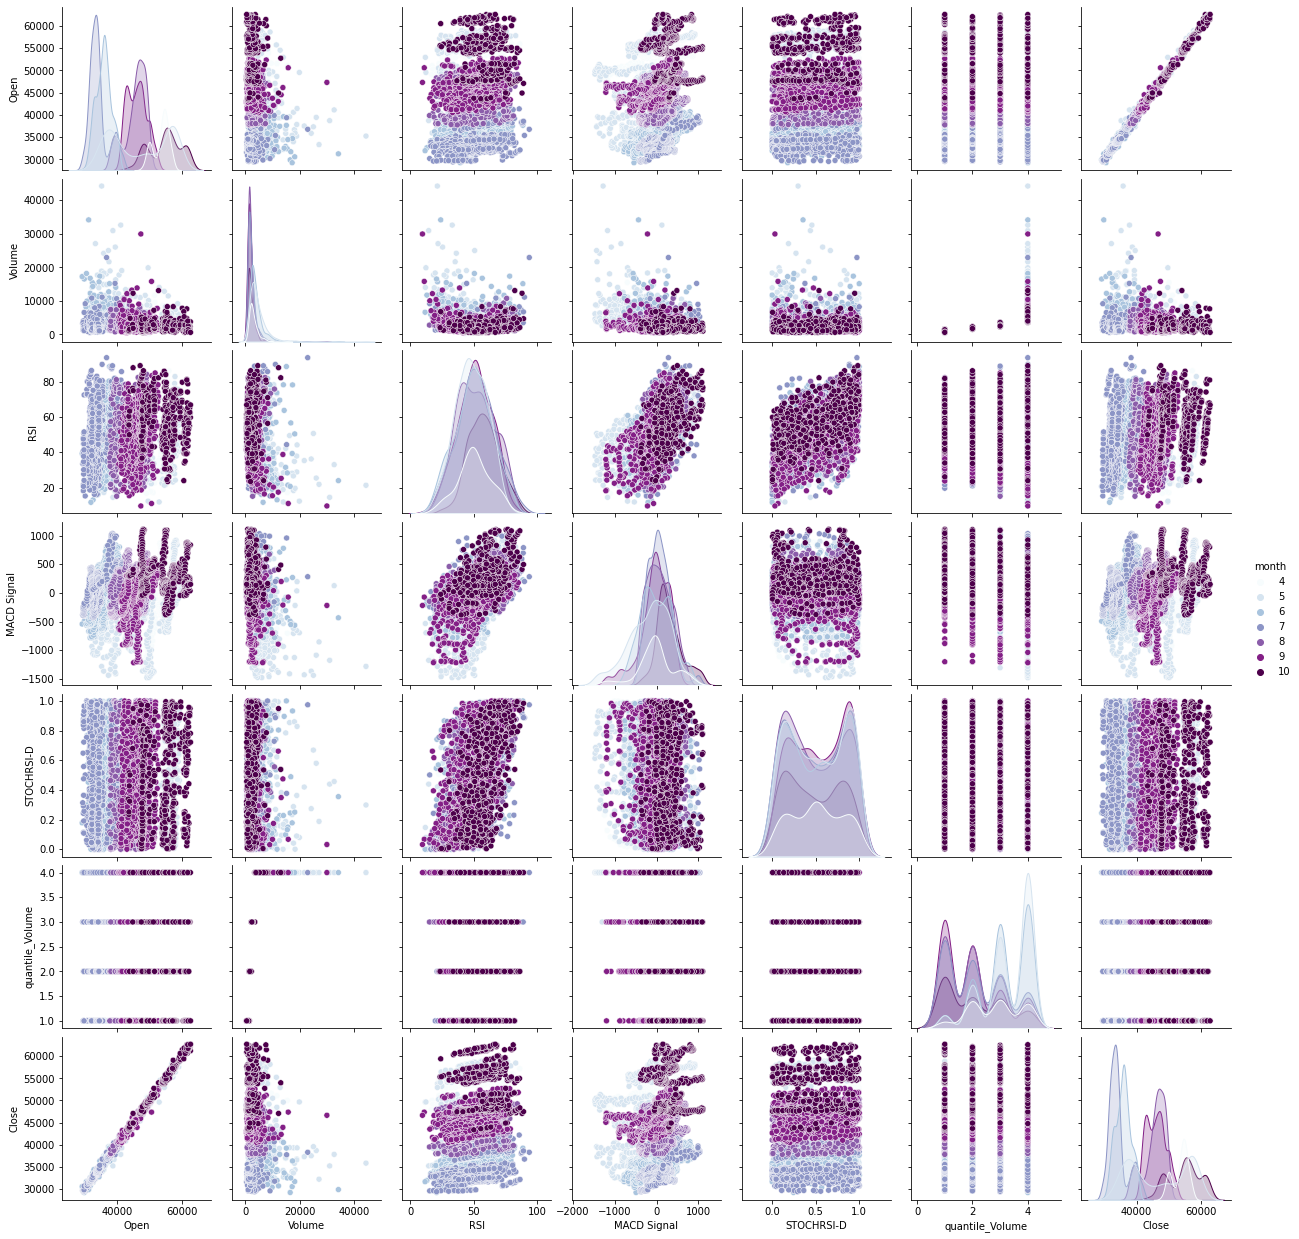

In [17]:
sns.pairplot(data[columns], diag_kind='kde', palette='BuPu', hue='month')
plt.show()

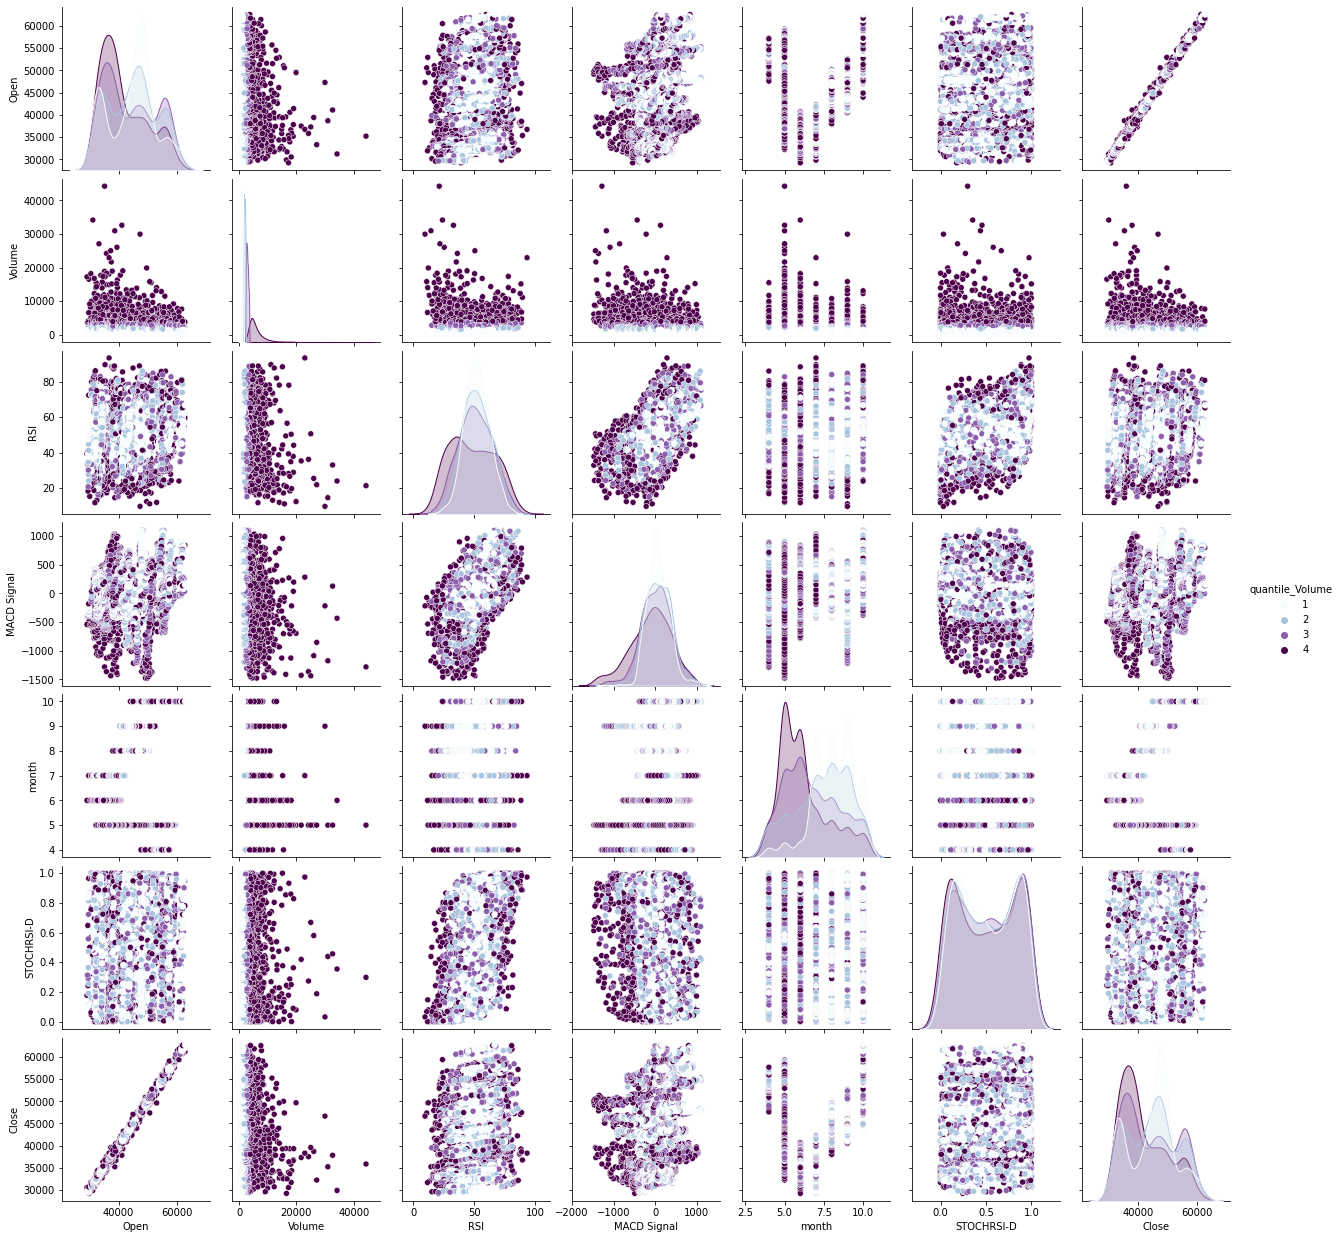

In [18]:
sns.pairplot(data[columns], diag_kind='kde', palette='BuPu', hue='quantile_Volume')
plt.show()

**Conditional distributions**

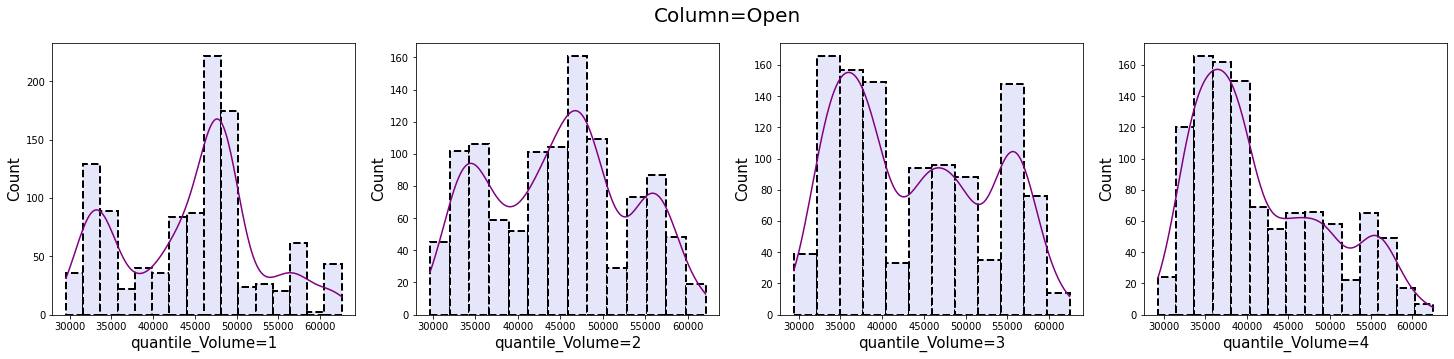

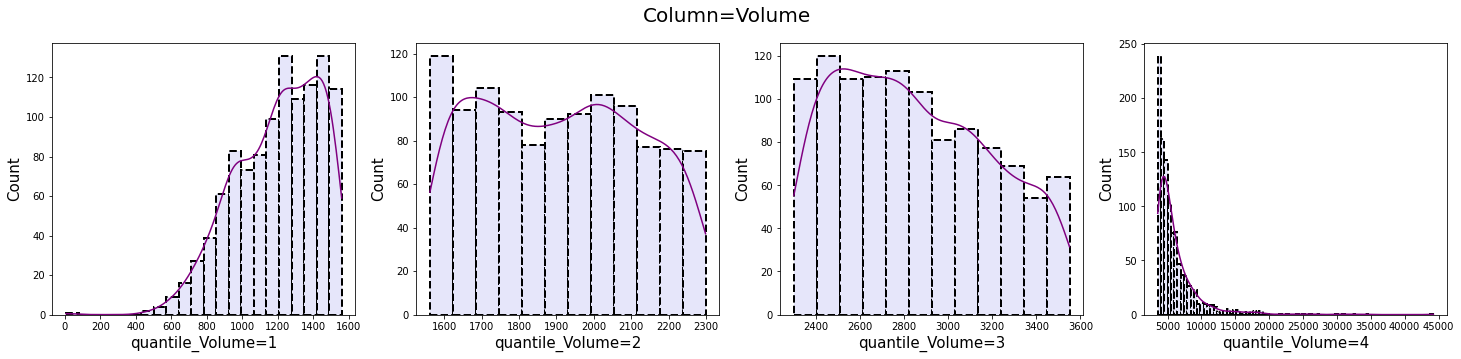

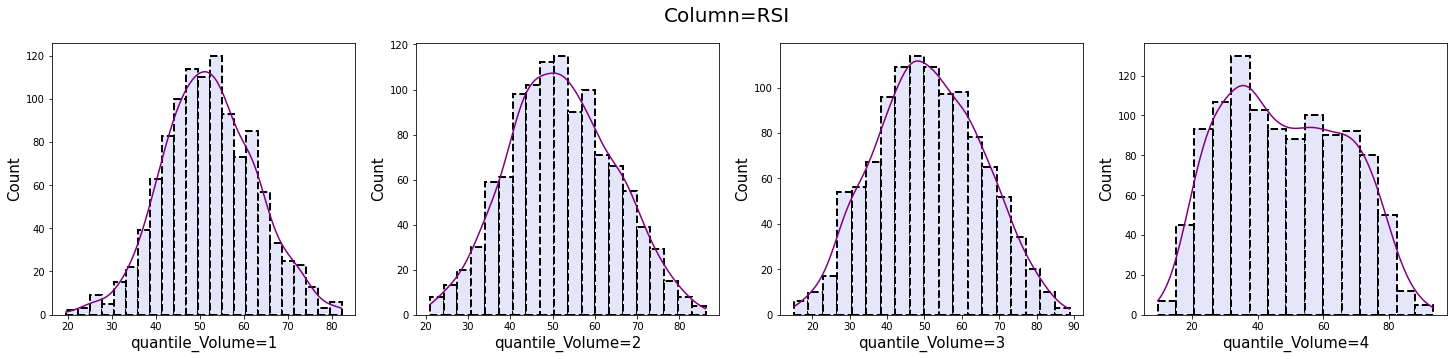

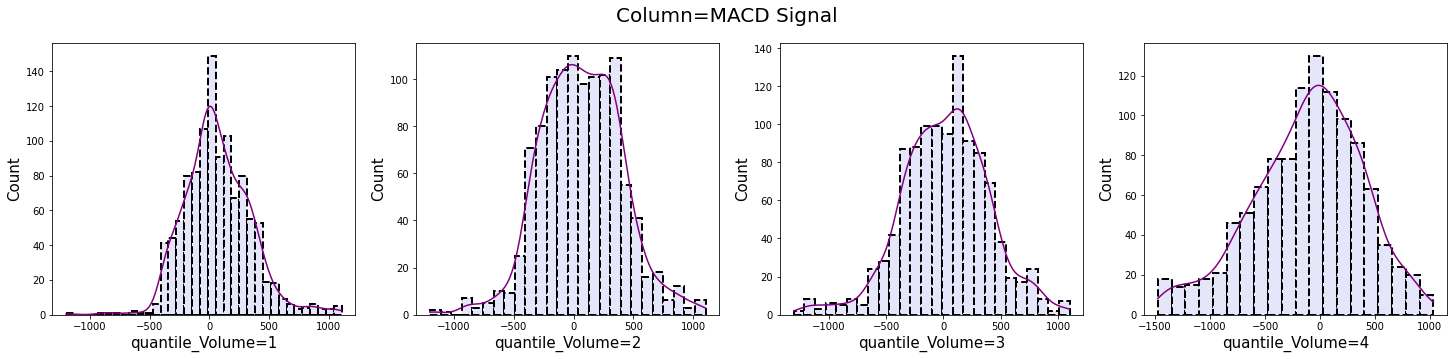

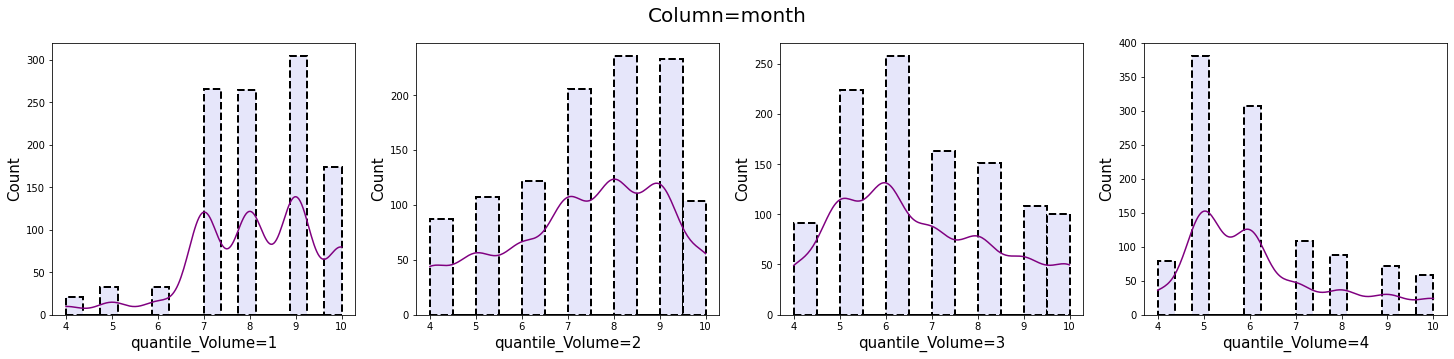

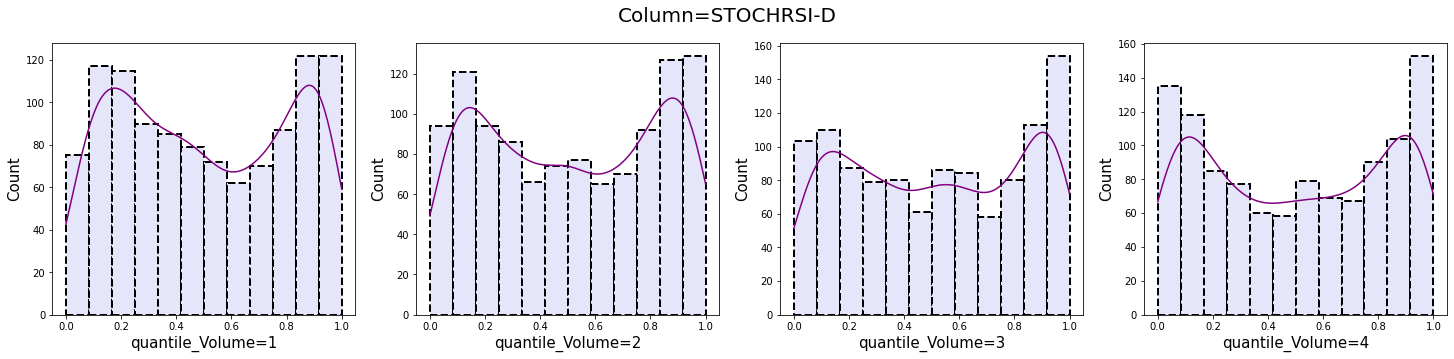

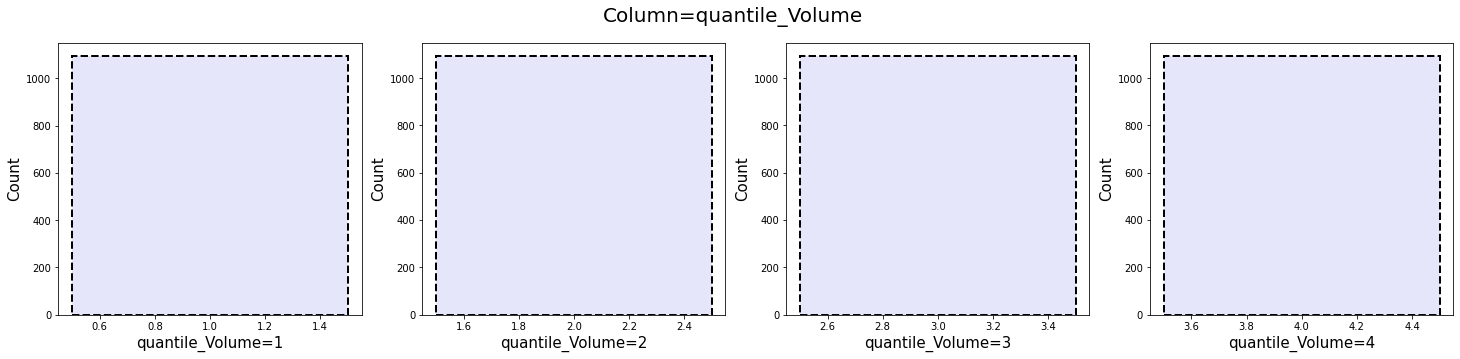

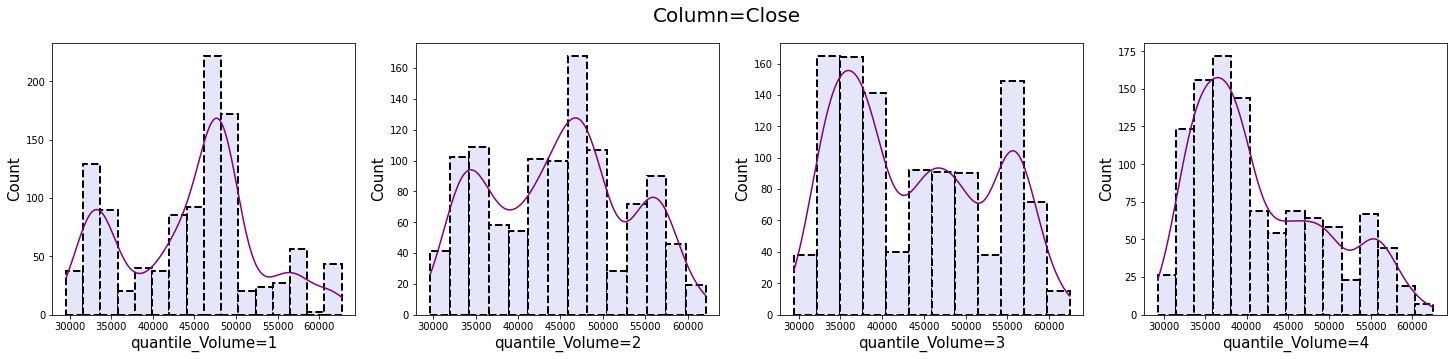

In [19]:
conditions = np.sort(data['quantile_Volume'].unique())

for col in columns:
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))
    for ax, cols in zip(ax.flat, conditions):

        condition_df = data[
            data['quantile_Volume'] == cols
        ]
        sns.histplot(
            condition_df[col],
            ax=ax,
            kde=True,
            **hist_plot_kwargs
        )
        ax.set_xlabel(f'quantile_Volume={cols}', fontsize=15)
        ax.set_ylabel('Count', fontsize=15)
        try:
            ax.lines[0].set_color('purple')
        except:
            continue
        
    fig.suptitle(f'Column={col}', fontsize=20)
    plt.show()

Let's count mathematical expectation and variance of conditional distribution and show it in table.

In [20]:
cond_mean = {}
cond_var = {}

for condition in conditions:
    condition_df = (
        data[data['quantile_Volume'] == condition]
        .drop('quantile_Volume', axis=1)
    )
    df_mean = condition_df.var(axis=0)
    df_mean.index = [f'mean_{x}' for x in df_mean.index]
    df_var = condition_df.mean(axis=0)
    df_var.index = [f'var_{x}' for x in df_var.index]
    cond_mean[f'quantile_Volume={condition}'] = df_mean
    cond_var[f'quantile_Volume={condition}'] = df_var

In [21]:
pd.DataFrame(cond_mean)

quantile_Volume=1  quantile_Volume=2  quantile_Volume=3  \
mean_Open              6.470311e+07       6.686893e+07       7.559168e+07   
mean_Volume            5.712776e+04       4.520472e+04       1.198644e+05   
mean_RSI               1.078101e+02       1.530043e+02       1.963207e+02   
mean_MACD Signal       7.512455e+04       1.122182e+05       1.432975e+05   
mean_month             1.830923e+00       2.996524e+00       3.077789e+00   
mean_STOCHRSI-D        9.287287e-02       9.792741e-02       9.968853e-02   
mean_Close             6.472727e+07       6.693694e+07       7.560658e+07   

                  quantile_Volume=4  
mean_Open              6.151362e+07  
mean_Volume            1.261243e+07  
mean_RSI               3.359093e+02  
mean_MACD Signal       2.466097e+05  
mean_month             2.480985e+00  
mean_STOCHRSI-D        1.077437e-01  
mean_Close             6.151082e+07

In [22]:
pd.DataFrame(cond_var)

quantile_Volume=1  quantile_Volume=2  quantile_Volume=3  \
var_Open              44555.475383       44868.400411       43955.143799   
var_Volume             1202.160961        1909.361322        2847.455732   
var_RSI                  52.202464          52.222315          51.065099   
var_MACD Signal          69.277297          64.243045          17.243959   
var_month                 8.128650           7.380822           6.715068   
var_STOCHRSI-D            0.506549           0.513545           0.517946   
var_Close             44567.078905       44867.676795       43960.847087   

                 quantile_Volume=4  
var_Open              41599.232237  
var_Volume             6118.444216  
var_RSI                  48.224974  
var_MACD Signal        -113.542551  
var_month                 6.180822  
var_STOCHRSI-D            0.503308  
var_Close             41587.903516

## Subtask 4.

*An estimation of pair correlation coefficients, confidence intervals for them and significance levels.*

Let's visualise correlation matrix

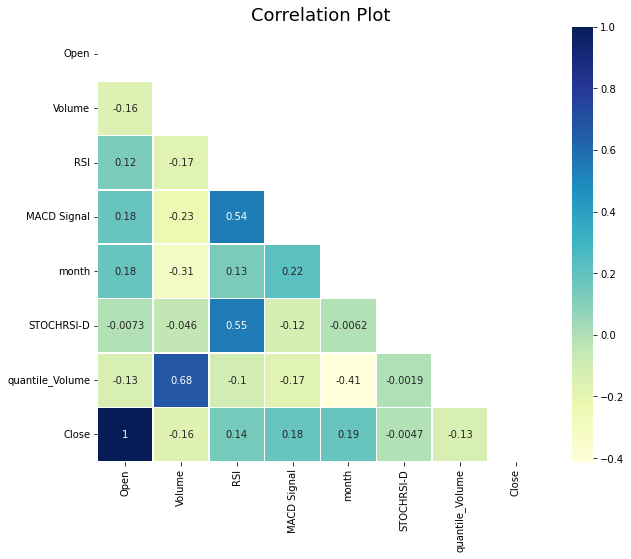

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

corr = data[columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            ax=ax, 
            vmax=1, 
            fmt='.2g', 
            linewidths=.5,
            cmap="YlGnBu")

ax.set_title('Correlation Plot', fontsize=18)
plt.show()

In [24]:
import copy

corr_coef = copy.deepcopy(corr)
corr_coef = corr_coef.astype(object)

And count confidence interval for each correlation.

In [25]:
from scipy import stats

alpha = 0.05

for index, col in enumerate(columns):
    for k in range(index + 1, len(columns)):
        # Code from workshop 2
        col2 = columns[k]
        x1, x2 = data[col], data[col2]
        coeff, p = stats.pearsonr(x1, x2)
        coeff_z = np.arctanh(coeff)
        std = 1 / np.sqrt(x1.size-3)
        z = stats.norm.ppf(1 - alpha / 2)
        low_z, high_z = coeff_z - z * std, coeff_z + z * std
        
        output_string = f'({low_z:.3},{high_z:.3})'
        corr_coef.at[col, col2] = output_string
        corr_coef.at[col2, col] = output_string

corr_coef.values[tuple([np.arange(corr_coef.shape[0])]*2)] = '(1.0, 1.0)'

DataFrame of confidence interval (left and right interval for coefficient)

In [26]:
corr_coef

Open             Volume              RSI  \
Open                   (1.0, 1.0)    (-0.191,-0.132)   (0.0948,0.154)   
Volume            (-0.191,-0.132)         (1.0, 1.0)  (-0.203,-0.144)   
RSI                (0.0948,0.154)    (-0.203,-0.144)       (1.0, 1.0)   
MACD Signal         (0.157,0.216)     (-0.269,-0.21)    (0.573,0.632)   
month               (0.157,0.216)    (-0.355,-0.295)     (0.101,0.16)   
STOCHRSI-D       (-0.0369,0.0223)  (-0.0758,-0.0166)    (0.582,0.641)   
quantile_Volume   (-0.162,-0.103)       (0.791,0.85)  (-0.133,-0.074)   
Close                 (3.73,3.79)    (-0.195,-0.136)    (0.113,0.172)   

                      MACD Signal             month         STOCHRSI-D  \
Open                (0.157,0.216)     (0.157,0.216)   (-0.0369,0.0223)   
Volume             (-0.269,-0.21)   (-0.355,-0.295)  (-0.0758,-0.0166)   
RSI                 (0.573,0.632)      (0.101,0.16)      (0.582,0.641)   
MACD Signal            (1.0, 1.0)     (0.194,0.254)   (-0.146,-0.0872)   
month               (0.194,0.254)        (1.0, 1.0)   (-0.0358,0.0234)   
STOCHRSI-D       (-0.146,-0.0872)  (-0.0358,0.0234)         (1.0, 1.0)   
quantile_Volume   (-0.203,-0.144)   (-0.467,-0.408)   (-0.0315,0.0277)   
Close               (0.157,0.216)     (0.158,0.217)   (-0.0343,0.0249)   

                  quantile_Volume             Close  
Open              (-0.162,-0.103)       (3.73,3.79)  
Volume               (0.791,0.85)   (-0.195,-0.136)  
RSI               (-0.133,-0.074)     (0.113,0.172)  
MACD Signal       (-0.203,-0.144)     (0.157,0.216)  
month             (-0.467,-0.408)     (0.158,0.217)  
STOCHRSI-D       (-0.0315,0.0277)  (-0.0343,0.0249)  
quantile_Volume        (1.0, 1.0)   (-0.163,-0.104)  
Close             (-0.163,-0.104)        (1.0, 1.0)

## Subtask 5 + 6.

**Task formulation**:

Predict target column `target = 'Close'` by columns:

```python
columns = [
    'Open', 
    'High', 
    'Low', 
    'Volume', 
    'RSI', 
    'MACD Signal', 
    'month', 
    'quantile_Volume'
]
```


In [87]:
X = data[features + categories] # predictors
y = data[target] # target

## Regression

We are applying cross validation in 10 Folds for regression model with different splits on train ann test size.

In [52]:
mae = []
rmse = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=i, 
        shuffle=True
    )
    lr = make_pipeline(
        StandardScaler(with_mean=False), 
        LinearRegression()
    )
    lr.fit(X_train, y_train)

    prediction = lr.predict(X_test)
    mae.append(
        mean_absolute_error(y_test, prediction)
    )
    rmse.append(
        mean_squared_error(y_test, prediction, squared=False)
    )

print(f'Mean MAE = {np.mean(mae)}')
print(f'Mean RMSE = {np.mean(rmse)}')

Mean MAE = 217.542443091694
Mean RMSE = 303.420152442206


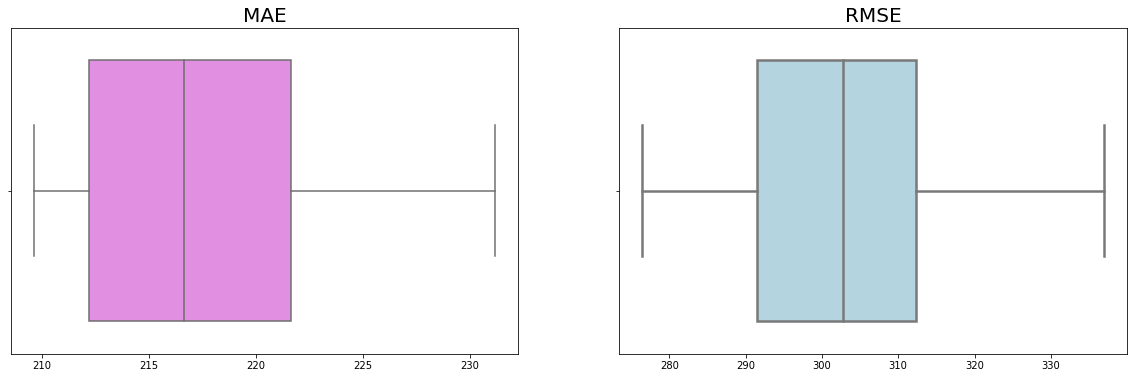

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(x=mae, ax=ax[0], color='violet')
sns.boxplot(x=rmse, ax=ax[1], linewidth=2.5, color='lightblue')
ax[0].set_title('MAE', fontsize=20)
ax[1].set_title('RMSE', fontsize=20)
plt.show()

## Lasso

Let's find the best value for alpha with Lasso Regression - we believe, that model will not overfitted on only one feature.

In [74]:
import typing as t

def find_best_alpha(
    sklearn_model: t.Union[Lasso, Ridge], 
    alphas: np.array = None,
    test_size: float = 0.2
):
    if alphas is None:
        alphas = np.linspace(0.001, 1, 100)
    
    best_rmse = float('inf')
    best_alpha = float('inf')
    best_mae = float('inf')
    
    for alpha in alphas: 
        mae = []
        rmse = []
        model = sklearn_model(alpha=alpha, max_iter=1000000)
        for i in range(10):
            X_train, X_test, y_train, y_test = train_test_split(
                X, 
                y, 
                test_size=test_size, 
                random_state=i, 
                shuffle=True
            )
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            mae.append(
                mean_absolute_error(y_test, prediction)
            )
            rmse.append(
                mean_squared_error(y_test, prediction, squared=False)
            )
        if np.mean(rmse) <= best_rmse:
            best_rmse = np.mean(rmse)
            best_alpha = alpha
            best_mae = np.mean(mae)
            
    print(f'Best alpha {sklearn_model.__name__} Regression = {best_alpha}')
    print(f'Best rmse {sklearn_model.__name__} Regression = {best_rmse}')
    
    return best_alpha, best_rmse

In [75]:
best_alpha_lasso, best_rmse_lasso = find_best_alpha(Lasso)

Best alpha Lasso Regression = 0.767909090909091
Best rmse Lasso Regression = 303.39560693988864


## Ridge Regression

The same for ridge regression.

In [76]:
best_alpha_ridge, best_rmse_ridge = find_best_alpha(Ridge)

Best alpha Ridge Regression = 1.0
Best rmse Ridge Regression = 303.4169257101388


As we can see the best model is `LassoRegression` with coefficient of regularization `alpha=0.76`. Let's fit and find residulas for this model.

In [77]:
model = Lasso(
    alpha=best_alpha_lasso, 
    max_iter=1000000
)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0, 
    shuffle=True
)

predictions = np.array(lr.predict(X_train))
true_values = np.array(y_train)

residuals = true_values - predictions

## Subtask 7.

*Analyze the quality of regression model*


Calculate `Variance inflation factor`

In [79]:
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor
)

In [80]:
vif_data = pd.DataFrame()
vif_data["features"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) 
    for i in range(len(X.columns))
]

In [81]:
vif_data

features        VIF
0             Open  21.822346
1           Volume   4.490120
2              RSI  32.136749
3      MACD Signal   1.852232
4            month  15.508952
5       STOCHRSI-D   7.393802
6  quantile_Volume  10.405280

Let's seethe distribution of residuals - normal!

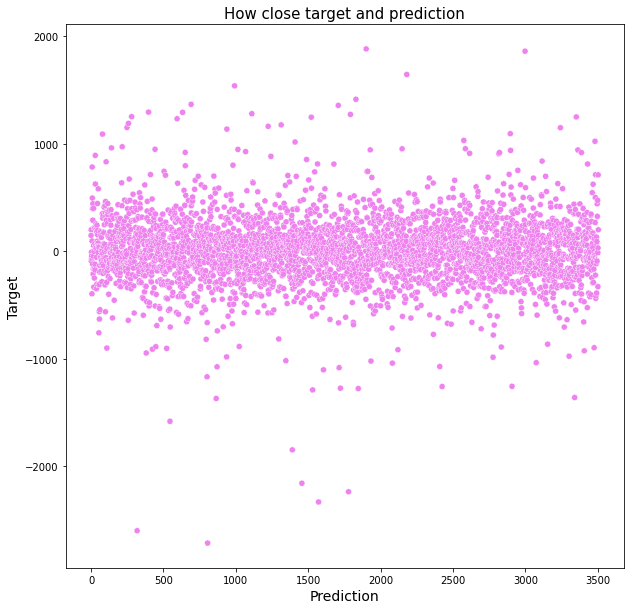

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x=range(predictions.shape[0]), 
    y=residuals, 
    ax=ax,
    color='violet',
    marker='o',
    linestyle='--'
)

ax.set_xlabel('Prediction', fontsize=14)
ax.set_ylabel('Target', fontsize=14)
ax.set_title('How close target and prediction', fontsize=15)
plt.show()

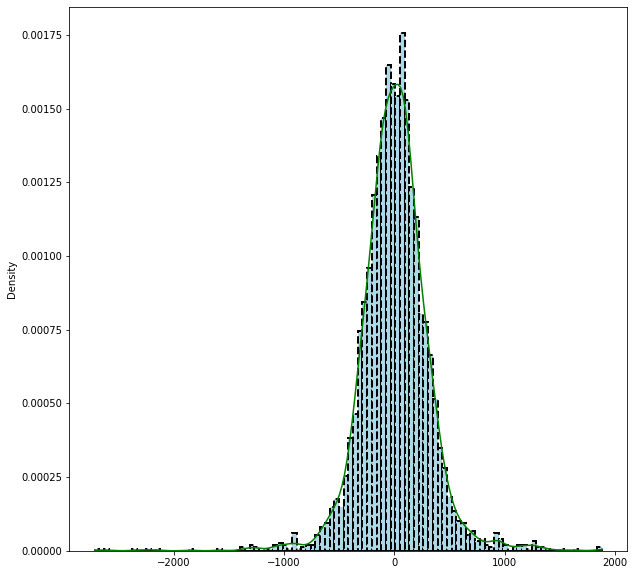

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.histplot(
    residuals, 
    ax=ax, 
    kde=True, 
    stat='density',
    **{**hist_plot_kwargs, 
       **{'color': 'lightblue'}}
)
ax.lines[0].set_color('green')
plt.show()